In [1]:
import getpass
import json
import os
import pathlib
import re
import time
from glob import glob
import requests
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
import xarray as xr
import folium

In [ ]:
#cr_url = "https://sos.iowa.gov/shapefiles/City%20Precincts/Cedar%20Rapids%20Precinct%20Boundaries.zip"

#cr_boundary = gpd.read_file(cr_url)
#cr_boundary

In [23]:
os.chdir(os.path.join(pathlib.Path.home(), 'Desktop', 'cr-ndvi'))

In [ ]:
os.listdir()

In [24]:
cr_dir = os.path.join(pathlib.Path.home(), 'Desktop', 'cr-ndvi')

cr_dir

'/Users/nate/Desktop/cr-ndvi'

In [4]:
cr_path = os.path.join('Cedar_Rapids_51_Precincts_-_No_County.shp')

cr_gdf = gpd.read_file(cr_path).dissolve()
cr_gdf

,geometry,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET_DEV
0,"POLYGON ((-91.64995 41.90342, -91.65247 41.903...",Cedar Rapids 01,CR01,1,-211298291,3466,-34


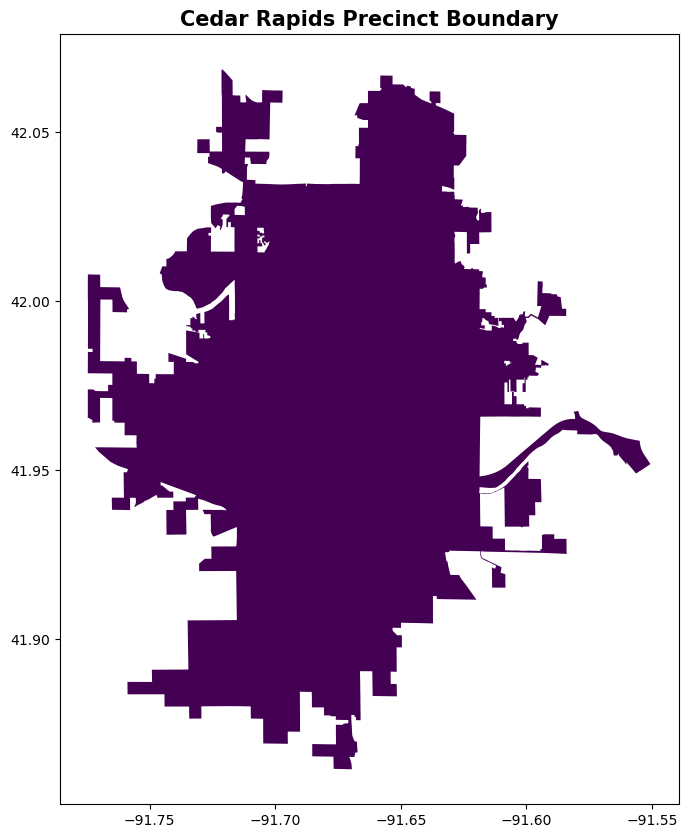

In [5]:
fig, ax = plt.subplots(figsize=(8,10))
cr_gdf.plot(column='DISTRICT',
                ax=ax)
plt.title('Cedar Rapids Precinct Boundary', fontweight='bold', fontsize=15)
plt.show()

### Bring in the raster data (NDVI)

In [14]:
cr_4269 = cr_gdf.to_crs('EPSG:4269')
print("the CRS for CR is:", cr_4269.crs)
cr_4269

the CRS for CR is: EPSG:4269


,geometry,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET_DEV
0,"POLYGON ((-91.64995 41.90342, -91.65247 41.903...",Cedar Rapids 01,CR01,1,-211298291,3466,-34


### 1. Log in to the Earthdata AppEEARS API

In [20]:
# Ask for the user's username and password
username = input('NASA Earthdata Username: ')
password = getpass.getpass('NASA Earthdata Password: ')

# Set up authentication and submit login request
s = requests.Session()
s.auth = (username, password)
login_resp = s.post("https://appeears.earthdatacloud.nasa.gov/api/login")

# Set up the authorization header with the new token to use in later commands
auth_header = (
    '{token_type} {token}'
    .format(**login_resp.json()))

NASA Earthdata Username: nquarderer
NASA Earthdata Password: ········


### 2. Submit the task request

In [ ]:
# Task parameters
task = {
    'task_type': 'area',
    'task_name': 'nd-ndvi',
    'params': {
        'dates': [
            {
                'startDate': '01-01-2018',
                'endDate': '12-31-2022'
            }
        ],
        'layers': [
            {
                'product': 'MOD13Q1.061',
                'layer': '_250m_16_days_NDVI'
            }
        ],
        # Need subdivisions as json, not as a string
        "geo": json.loads(cr_gdf.envelope.to_json()), 
        "output": {
            "format": {"type": "geotiff"}, 
            "projection": "geographic"
        }
    }
}

# Submit the task request
task_response = requests.post(
    'https://appeears.earthdatacloud.nasa.gov/api/task', 
    json=task, 
    headers={'Authorization': auth_header})

# We need the task ID for later
task_id = task_response.json()['task_id']

In [ ]:
pwd

### Wait for the download

In [ ]:
status = 'initializing'
while status != 'done':
    # Wait 20 seconds in between status checks
    if status != 'initializing':
        time.sleep(20)

    # Check status
    status_response = requests.get(
        'https://appeears.earthdatacloud.nasa.gov/api/status/{}'
        .format(task_id), 
        headers={'Authorization': auth_header})
    
    # Update status
    if 'progress' in status_response.json():
        status = status_response.json()['progress']['summary']
    elif 'status' in status_response.json():
        status = status_response.json()['status']
    print(status)

### Download data

In [ ]:
# Get file download information
bundle_response = requests.get(
    'https://appeears.earthdatacloud.nasa.gov/api/bundle/{}'
    .format(task_id),
    headers={'Authorization': auth_header}
)
files = bundle_response.json()['files']

'{} files available for download'.format(len(files))

# Download files
for file_info in files:
    # Get a stream to the bundle file
    response = requests.get( 
        'https://appeears.earthdatacloud.nasa.gov/api/bundle/{}/{}'
        .format(task_id, file_info['file_id']),  
        headers={'Authorization': auth_header}, 
        allow_redirects=True,
        stream=True
    ) 

    # Create a destination directory to store the file in
    filepath = os.path.join(cr_dir, file_info['file_name'])
    if not os.path.exists(os.path.dirname(filepath)):
        os.makedirs(os.path.dirname(filepath))

    # Write the file to the destination directory
    print('Downloading file {}'.format(filepath))
    with open(filepath, 'wb') as f:
        for data in response.iter_content(chunk_size=8192):
            f.write(data)

In [9]:
ndvi_paths = sorted(glob(os.path.join(cr_dir, '*', '*NDVI*.tif')))
ndvi_paths

['/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_2017351_to_2022365/MOD13Q1.061__250m_16_days_NDVI_doy2017353_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_2017351_to_2022365/MOD13Q1.061__250m_16_days_NDVI_doy2018001_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_2017351_to_2022365/MOD13Q1.061__250m_16_days_NDVI_doy2018017_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_2017351_to_2022365/MOD13Q1.061__250m_16_days_NDVI_doy2018033_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_2017351_to_2022365/MOD13Q1.061__250m_16_days_NDVI_doy2018049_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_2017351_to_2022365/MOD13Q1.061__250m_16_days_NDVI_doy2018065_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_2017351_to_2022365/MOD13Q1.061__250m_16_days_NDVI_doy2018081_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_2017351_to_2022365/MOD13Q1.061__250m_16_days_NDVI_doy2018097_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_2017351_to_2022365/MOD

In [10]:
summer_months = ['June', 'July', 'August']
scale_factor = 10000
doy_start = -19
doy_end = -12

ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Skip non-summer months
    if not (date.month_name() in summer_months):
        continue

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Multiple by scale factor
    da = da / scale_factor

    # Prepare for concatenation
    ndvi_das.append(da)

len(ndvi_das)
# END SOLUTION

30

In [11]:
ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_da

<xarray.Dataset>
Dimensions:      (x: 108, y: 100, date: 30)
Coordinates:
    band         int64 1
  * x            (x) float64 -91.77 -91.77 -91.77 ... -91.56 -91.55 -91.55
  * y            (y) float64 42.07 42.07 42.06 42.06 ... 41.87 41.87 41.86 41.86
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2018-06-10 2018-06-26 ... 2022-08-29
Data variables:
    NDVI         (date, y, x) float32 0.6769 0.6769 0.7087 ... 0.8324 0.8324

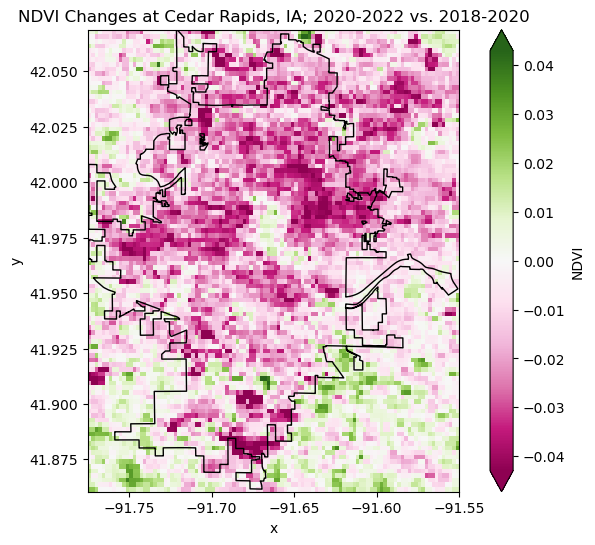

In [12]:
# BEGIN SOLUTION
ndvi_diff = (
    ndvi_da
        .sel(date=slice('2020', '2022'))
        .mean('date')
        .NDVI 
   - ndvi_da
        .sel(date=slice('2018', '2022'))
        .mean('date')
        .NDVI 
)

fig, ax = plt.subplots(figsize=(8,6))
#water.plot(ax=ax, color='lightblue', alpha=0.7)
ndvi_diff.plot(cmap=plt.cm.PiYG, robust=True, ax=ax)
#woodlands.plot(ax=plt.gca(), facecolor='none', edgecolor='black')
cr_gdf.plot(ax=ax, color='none', edgecolor='black')
plt.title("NDVI Changes at Cedar Rapids, IA; 2020-2022 vs. 2018-2020")
plt.show()
# END SOLUTION

### Submit 2nd request (looking at pre/post 2008 flood)

In [25]:
# Task parameters
task = {
    'task_type': 'area',
    'task_name': 'nd-ndvi',
    'params': {
        'dates': [
            {
                'startDate': '01-01-2000',
                'endDate': '12-31-2017'
            }
        ],
        'layers': [
            {
                'product': 'MOD13Q1.061',
                'layer': '_250m_16_days_NDVI'
            }
        ],
        # Need subdivisions as json, not as a string
        "geo": json.loads(cr_4269.envelope.to_json()), 
        "output": {
            "format": {"type": "geotiff"}, 
            "projection": "geographic"
        }
    }
}

# Submit the task request
task_response = requests.post(
    'https://appeears.earthdatacloud.nasa.gov/api/task', 
    json=task, 
    headers={'Authorization': auth_header})

# We need the task ID for later
task_id = task_response.json()['task_id']

In [26]:
status = 'initializing'
while status != 'done':
    # Wait 20 seconds in between status checks
    if status != 'initializing':
        time.sleep(20)

    # Check status
    status_response = requests.get(
        'https://appeears.earthdatacloud.nasa.gov/api/status/{}'
        .format(task_id), 
        headers={'Authorization': auth_header})
    
    # Update status
    if 'progress' in status_response.json():
        status = status_response.json()['progress']['summary']
    elif 'status' in status_response.json():
        status = status_response.json()['status']
    print(status)

0
9
16
24
31
38
46
49
52
55
57
60
63
65
68
71
74
77
79
82
90
95
95
95
95
done


In [ ]:
# Get file download information
bundle_response = requests.get(
    'https://appeears.earthdatacloud.nasa.gov/api/bundle/{}'
    .format(task_id),
    headers={'Authorization': auth_header}
)
files = bundle_response.json()['files']

'{} files available for download'.format(len(files))

# Download files
for file_info in files:
    # Get a stream to the bundle file
    response = requests.get( 
        'https://appeears.earthdatacloud.nasa.gov/api/bundle/{}/{}'
        .format(task_id, file_info['file_id']),  
        headers={'Authorization': auth_header}, 
        allow_redirects=True,
        stream=True
    ) 

    # Create a destination directory to store the file in
    filepath = os.path.join(cr_dir, file_info['file_name'])
    if not os.path.exists(os.path.dirname(filepath)):
        os.makedirs(os.path.dirname(filepath))

    # Write the file to the destination directory
    print('Downloading file {}'.format(filepath))
    with open(filepath, 'wb') as f:
        for data in response.iter_content(chunk_size=8192):
            f.write(data)

In [29]:
ndvi_paths = sorted(glob(os.path.join(cr_dir, '*', '*NDVI*.tif')))
ndvi_paths

['/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_1999351_to_2017365/MOD13Q1.061__250m_16_days_NDVI_doy2000049_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_1999351_to_2017365/MOD13Q1.061__250m_16_days_NDVI_doy2000065_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_1999351_to_2017365/MOD13Q1.061__250m_16_days_NDVI_doy2000081_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_1999351_to_2017365/MOD13Q1.061__250m_16_days_NDVI_doy2000097_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_1999351_to_2017365/MOD13Q1.061__250m_16_days_NDVI_doy2000113_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_1999351_to_2017365/MOD13Q1.061__250m_16_days_NDVI_doy2000129_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_1999351_to_2017365/MOD13Q1.061__250m_16_days_NDVI_doy2000145_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_1999351_to_2017365/MOD13Q1.061__250m_16_days_NDVI_doy2000161_aid0001.tif',
 '/Users/nate/Desktop/cr-ndvi/MOD13Q1.061_1999351_to_2017365/MOD

In [30]:
summer_months = ['June', 'July', 'August']
scale_factor = 10000
doy_start = -19
doy_end = -12

ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Skip non-summer months
    if not (date.month_name() in summer_months):
        continue

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Multiple by scale factor
    da = da / scale_factor

    # Prepare for concatenation
    ndvi_das.append(da)

len(ndvi_das)
# END SOLUTION

138

In [31]:
ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_da

<xarray.Dataset>
Dimensions:      (x: 108, y: 100, date: 138)
Coordinates:
    band         int64 1
  * x            (x) float64 -91.77 -91.77 -91.77 ... -91.56 -91.55 -91.55
  * y            (y) float64 42.07 42.07 42.06 42.06 ... 41.87 41.87 41.86 41.86
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2000-06-09 2000-06-25 ... 2022-08-29
Data variables:
    NDVI         (date, y, x) float32 0.7785 0.7785 0.796 ... 0.8324 0.8324

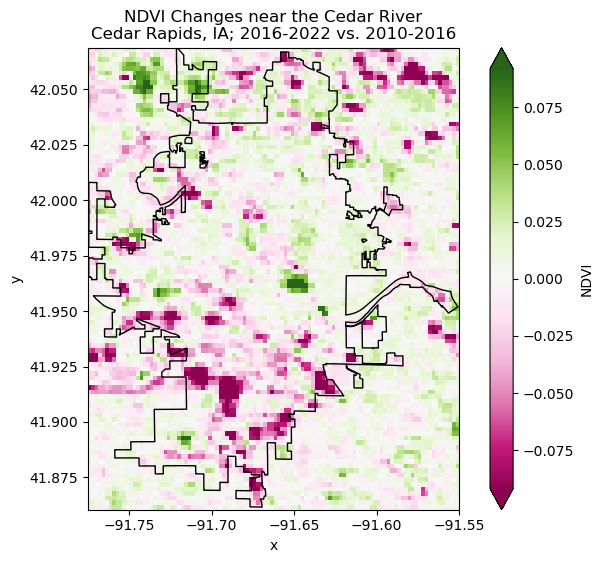

In [35]:
# BEGIN SOLUTION
ndvi_diff = (
    ndvi_da
        .sel(date=slice('2008', '2016'))
        .mean('date')
        .NDVI 
   - ndvi_da
        .sel(date=slice('2000', '2008'))
        .mean('date')
        .NDVI 
)

fig, ax = plt.subplots(figsize=(8,6))
ndvi_diff.plot(cmap=plt.cm.PiYG, robust=True, ax=ax)
#woodlands.plot(ax=plt.gca(), facecolor='none', edgecolor='black')
#water.plot(ax=ax, color='lightblue', edgecolor='grey')
cr_gdf.plot(ax=ax, color='none', edgecolor='black')
plt.title("NDVI Changes near the Cedar River\nCedar Rapids, IA; 2008-2016 vs. 2000-2008")
plt.show()
# END SOLUTION